In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df=pd.read_csv("Churn_Modelling.csv", sep=",")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Index(['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')


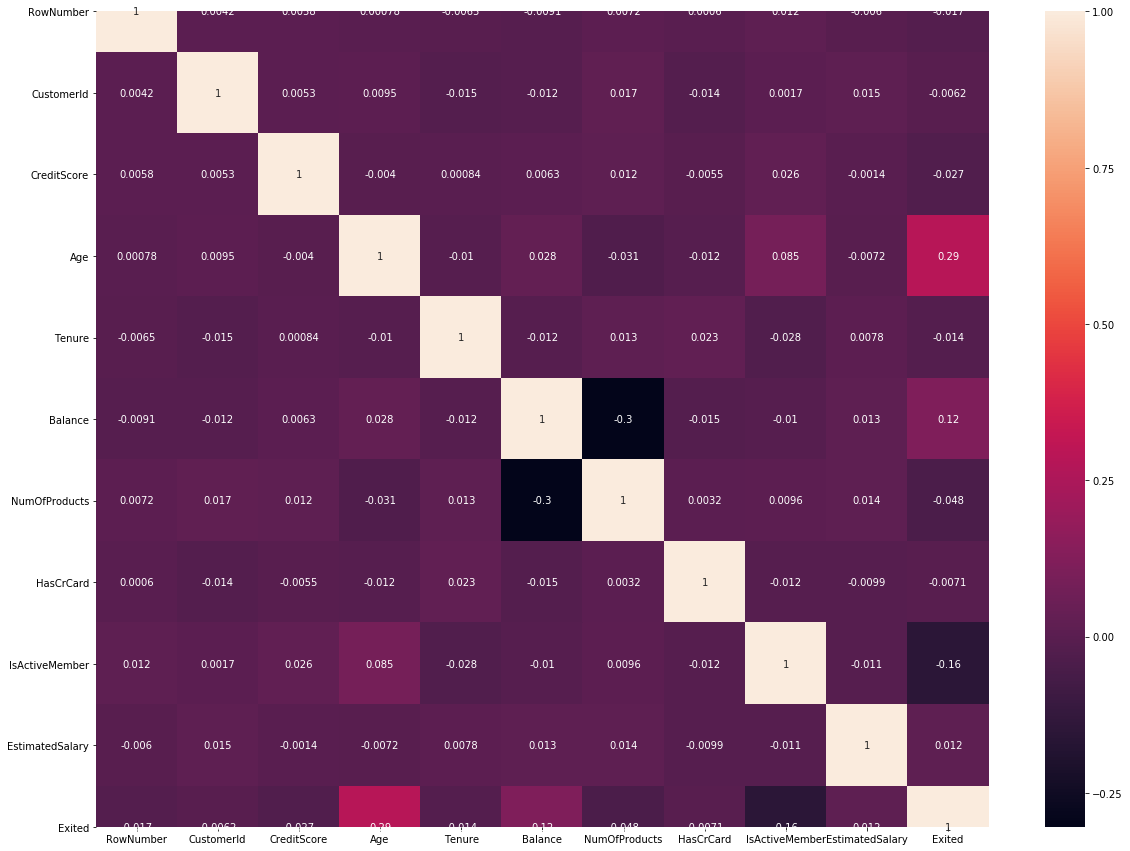

In [2]:
import seaborn as sns
corr_features=df.corr()
top_corr_features=corr_features.index
print(top_corr_features)
plt.figure(figsize=(20, 15))

g=sns.heatmap(df[top_corr_features].corr(), annot=True)

In [3]:
X=df.iloc[:, 3:14]
y=df.iloc[:, -1]
(X.shape, y.shape)

((10000, 11), (10000,))

In [4]:
df.Geography.value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [5]:
df.Gender.value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [6]:
geography_dummy=pd.get_dummies(df.Geography, drop_first=True)
gender_dummy=pd.get_dummies(df.Gender, drop_first=True)

In [7]:
X=pd.concat([X, geography_dummy, gender_dummy], axis=1).drop(['Exited', 'Gender', "Geography"], axis=1)
X.shape

(10000, 11)

In [8]:
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Germany,Spain,Male
0,619,42,2,0.00,1,1,1,101348.88,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0


In [9]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X=sc.fit(X).transform(X)

In [10]:
## Hyper Parameter Optimisation using XGBOOST
r=np.arange(2, 20)
param_grid={
    
    'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    'max_depth': r,
    'gamma': [0.0, 0.01, 0.001, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 2, 3 , 4, 5, 6, 7, 8, 9, 10],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7]
}

In [11]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost

In [12]:
model=xgboost.XGBClassifier()

In [13]:
random_search=RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=5, n_iter=5, scoring='roc_auc', verbose=1)

In [14]:
result=random_search.fit(X, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   16.0s finished


In [15]:
print("Best Estimator is {} \nBest Score is {}\nBest Parameters: {}".format(
        result.best_estimator_, result.best_score_, result.best_params_
        )
    )

Best Estimator is XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.001,
              learning_rate=0.15, max_delta_step=0, max_depth=5,
              min_child_weight=6, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1) 
Best Score is 0.8660269645634843
Best Parameters: {'min_child_weight': 6, 'max_depth': 5, 'learning_rate': 0.15, 'gamma': 0.001, 'colsample_bytree': 0.4}


In [16]:
model=result.best_estimator_

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.1, random_state=100)

In [18]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.001,
              learning_rate=0.15, max_delta_step=0, max_depth=5,
              min_child_weight=6, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [20]:
pred=model.predict(X_test)
print("Accuracy Score: {}".format(accuracy_score(pred, y_test)))

Accuracy Score: 0.865


In [21]:
cm=confusion_matrix(y_test, pred)
cm

array([[775,  27],
       [108,  90]], dtype=int64)